# Building A Handwritten Digits Classifier
The goals of this Project to explore the effectiveness of deep, feedforward neural networks at classifying images. I will compare a Multi-layer Perceptron classifier (MLP) with Linear Regression and a Random Forest models while using different parameters setup.

Scikit-learn contains a number of [datasets](https://scikit-learn.org/stable/datasets/index.html) pre-loaded with the library, within the namespace of **sklearn.datasets**. The _load_digits()_ function returns a copy of the hand-written digits dataset from [UCI](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (8 x 8 pixels). To visualize the image, we need to reshape these pixel values back into the 8 by 8 and plot them on a coordinate grid.

For better results, I'm using a K-Fold technique to split the data in train and test sets. The K-Fold technique provides K times train and test sets and we will evaluate the mean performance of the model across them.

## Project setup

In [3]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
# ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
# Plots
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# Plot style setup
plt.style.use('ggplot')

## Dataset overview


In [5]:
dataset = load_digits()
data = pd.DataFrame(dataset['data'])
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0


In [6]:
target = pd.Series(dataset['target'])
target.shape

(1797,)

In [7]:
target.sample(10)

1213    1
1111    2
164     6
1095    4
666     0
1577    6
474     6
1461    5
1260    3
382     0
dtype: int64

To reshape the images, we need to convert a training example to a numpy array (excluding the label column) and pass the result into that into the _numpy.reshape()_ function.

In [8]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

Let's see some images and the target values from the dataset:

Targets
----
0
1
4
9
1
7
7
3


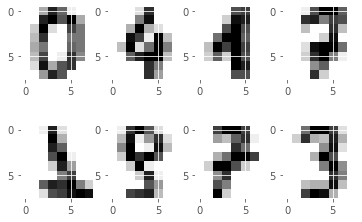

In [9]:
f, ax = plt.subplots(2, 4)

print('Targets')
print(4*'-')
for i in range(4):
    img_idx1 = i*100
    img_idx2 = 1000 + img_idx1
    # Setup the plot for a 2x4 layout, one image up and the other down
    image_r1 = data.iloc[img_idx1].values.reshape(8,8)
    image_r2 = data.iloc[img_idx2].values.reshape(8,8)
    # Show image
    ax[0, i].imshow(image_r1, cmap='gray_r')
    ax[1, i].imshow(image_r2, cmap='gray_r')
    # Print which is the target (label) value for each
    print(target.iloc[img_idx1])
    print(target.iloc[img_idx2])

## K-Nearest Neighbor modeling
We will use a pipeline across this project for training, testing and cross validating the models.
Later I will be re-writing the methods if needed.

In [41]:
def train(X, y, n):
    """
    Train a K-Nearest Neighbor model and return the trained model
    """
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X, y)

    return knn

In [42]:
def test(model, X_test, y_test):
    """
    Predict values using a trained model and return the predictions
    """
    score = model.score(X_test, y_test)
    return score

In [46]:
def cross_validate(features, labels, n, n_folds=4, learning_rate_init=0.001):
    """
    Validation based on train/test split using K-Folding
    """
    accuracies = []
    
    kf = KFold(n_splits = n_folds, random_state=2)
    
    for train_idx, test_idx in kf.split(features):
        
        # 'X' as features and 'y' as labels
        X = features.loc[train_idx]
        y = labels.loc[train_idx]
        X_test = features.loc[test_idx]
        y_test = labels.loc[test_idx]
        
        # Train and test the model
        model = train(X, y, n)
        model_score = test(model, X_test, y_test)
        
        # Save each score for further use
        accuracies.append(model_score)
        
    return accuracies

In [37]:
# simple test
scores = cross_validate(data, target, 3)
print(scores, np.mean(scores))

[0.7379859289291677, 0.6729725682545973, 0.7156766822516949, 0.6716148831641755] 0.6995625156499088


In [12]:
# test with different clusters quantity
avg_scores = []
neighbor_q = range(1,31)
for n in neighbor_q:
    scores = cross_validate(data, target, n)
    avg_scores.append(np.mean(scores))

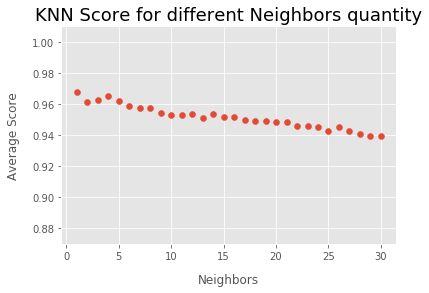

In [97]:
ax = plt.subplot()
plt.scatter(neighbor_q, avg_scores)
# Plot setup
ax.set_title('KNN Score for different Neighbors quantity', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neighbors', labelpad=12)
ax.set_ylim(0.87, 1.01)
plt.show()

It seems that the model cannot be improved by incrementing the neighbors quantity.

## Multi-layer Perceptron classifier modeling
We redefine _train()_ and _cross_validate()_ to match our MLP requirements.

In [47]:
# Redefine train(), then we can still use cross_validate()
def train(X, y, n=(100,), learning_rate_init=0.001):
    """
    Train a MLP Classifier model and return the trained model
    """
    mlp = MLPClassifier(hidden_layer_sizes=n, max_iter=2000, learning_rate_init=0.001)
    mlp.fit(X, y)

    return mlp

In [51]:
def cross_validate(features, labels, n, n_folds=4, learning_rate_init=0.001):
    """
    Validation based on train/test split using K-Folding
    """
    accuracies = []
    
    kf = KFold(n_splits = n_folds, random_state=2)
    
    for train_idx, test_idx in kf.split(features):
        
        # 'X' as features and 'y' as labels
        X = features.loc[train_idx]
        y = labels.loc[train_idx]
        X_test = features.loc[test_idx]
        y_test = labels.loc[test_idx]
        
        # Train and test the model
        model = train(X, y, n, learning_rate_init=learning_rate_init)
        model_score = test(model, X_test, y_test)
        
        # Save each score for later use
        accuracies.append(model_score)
        
    return accuracies

In [50]:
# Simple test
scores = cross_validate(data, target, (10,))
print(scores)
print(np.mean(scores))

[0.9266666666666666, 0.9153674832962138, 0.910913140311804, 0.8663697104677061]
0.9048292501855976


In [53]:
# Test with different neurons quantity
neurons_q = [8, 16, 32, 64, 128, 256]

In [54]:
# This model will use 1 hidden layer and 4 folds
avg_scores_1hl_4f = []

for n in neurons_q:
    scores = cross_validate(data, target, (n,))
    # Save each score for further use
    avg_scores_1hl_4f.append(np.mean(scores))

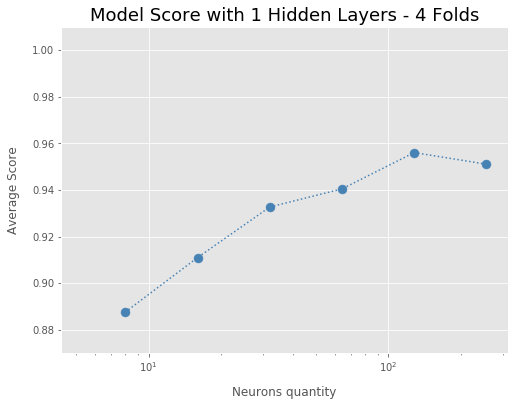

In [98]:
f, ax = plt.subplots(figsize=(8,6))

# 1 hidden layer
plt.plot(neurons_q, avg_scores_1hl_4f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_4f, s=80, c='steelblue')

# Plot setup
ax.set_title('Model Score with 1 Hidden Layers - 4 Folds', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.set_xscale('log')
ax.set_ylim(0.87, 1.01)
plt.show()

This model shows that the more neurons the hidden layer has, the better the model performance.

### Train and Test sets performance comparison
We can run a test to compare how the model performs using train and test sets for predictions. We suppose that the train set will perform always better that the test set. If the model is good, the performance between train and test sets should be similar. On the other side, if the performance is much lower with the test set compared to the train set, then the model may be overfitted.

In [52]:
def train_test_perf_comparison(features, labels, n):
    """
    Compare the performance with train and test sets.
    Models that overfit tend to perform well on the train set but
    poorly on the test 
    """
    accuracies_train = []
    accuracies_test = []
    
    kf = KFold(n_splits = 4, random_state=2)
    
    for train_idx, test_idx in kf.split(features):
        # 'X' as features and 'y' as labels
        X = features.loc[train_idx]
        y = labels.loc[train_idx]
        X_test = features.loc[test_idx]
        y_test = labels.loc[test_idx]

        # Train and test the model
        model = train(X, y, n)
        model_score_test = test(model, X_test, y_test)
        model_score_train = test(model, X, y)
        
        # Save both scores for later use
        accuracies_train.append(model_score_train)
        accuracies_test.append(model_score_test)
        
    return accuracies_train, accuracies_test

In [19]:
avg_scores_train = []
avg_scores_test = []
for n in neurons_q:
    s_train, s_test = train_test_perf_comparison(data, target, n)
    # Save mean scores for plotting
    avg_scores_train.append(np.mean(s_train))
    avg_scores_test.append(np.mean(s_test))

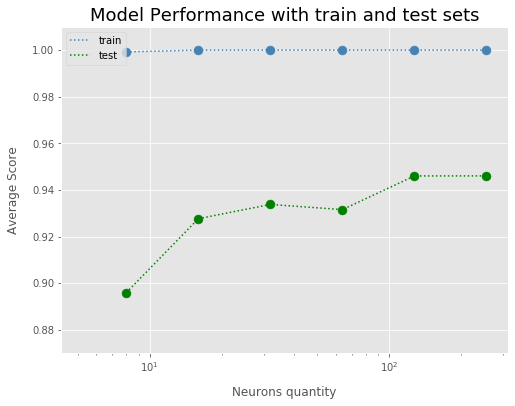

In [99]:
f, ax = plt.subplots(figsize=(8,6))

# Performance with train set
ax.plot(neurons_q, avg_scores_train, c='steelblue', ls=':', label='train')
ax.scatter(neurons_q, avg_scores_train, s=80, c='steelblue')

# Performance with test set
ax.plot(neurons_q, avg_scores_test, c='green', ls=':', label='test')
ax.scatter(neurons_q, avg_scores_test, s=80, c='green')

# Plot setup
ax.set_title('Model Performance with train and test sets', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
ax.set_ylim(0.87, 1.01)
plt.show()

We can confirm that the model's performance is poor when there are few neurons in the hidden layer. As the neurons quantity increases, the model improves. The improvement is not much when comparing the 64 neurons model to the 256 neurons. We should consider that the increase in neurons quantity makes the model slower and need more computing power. The final decision should evaluate a tradeoff between performance and computer resources.

### Increasing hidden layers
By increasing the quantity of hidden layer we should observe an overall increase in performance. We will run some tests to corroborate this behavior.

In [21]:
# This model uses 2 hidden layers and 4 folds
avg_scores_2hl_4f = []

for n in neurons_q:
    scores = cross_validate(data, target, (n,n))
    # Save mean scores for later use
    avg_scores_2hl_4f.append(np.mean(scores))

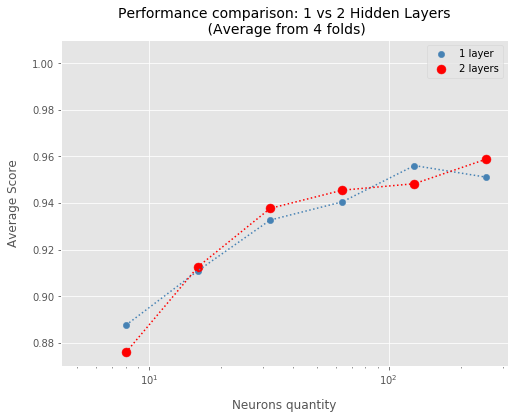

In [100]:
f, ax = plt.subplots(figsize=(8,6))

# 1 hidden layer performance
plt.plot(neurons_q, avg_scores_1hl_4f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_4f, s=40, c='steelblue', label='1 layer')

# 2 hidden layers performance
plt.plot(neurons_q, avg_scores_2hl_4f, c='r', ls=':')
plt.scatter(neurons_q, avg_scores_2hl_4f, s=80, c='r', label='2 layers')

# Plot setup
ax.set_title('Performance comparison: 1 vs 2 Hidden Layers\n \
(Average from 4 folds)', size=14)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
ax.set_ylim(0.87, 1.01)
plt.show()

Lets try now with 3 hidden layers:

In [23]:
# test with different neurons quantity in two hidden layer
avg_scores_3hl_4f = []
neurons_q = [8, 16, 32, 64, 128, 256]
for n in neurons_q:
    scores = cross_validate(data, target, (n,n,n))
    avg_scores_3hl_4f.append(np.mean(scores))

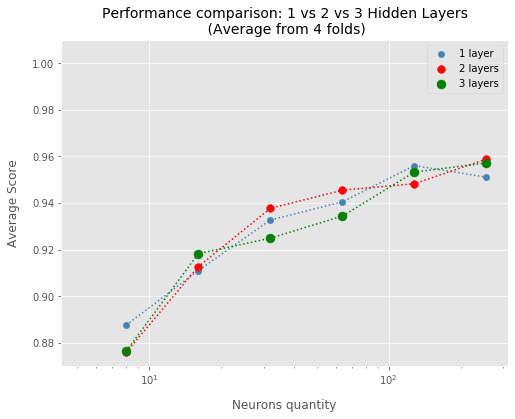

In [101]:
f, ax = plt.subplots(figsize=(8,6))

# 1 hidden layer
plt.plot(neurons_q, avg_scores_1hl_4f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_4f, s=40, c='steelblue', label='1 layer')

# 2 hidden layers
plt.plot(neurons_q, avg_scores_2hl_4f, c='r', ls=':')
plt.scatter(neurons_q, avg_scores_2hl_4f, s=60, c='r', label='2 layers')

# 3 hidden layers
plt.plot(neurons_q, avg_scores_3hl_4f, c='g', ls=':')
plt.scatter(neurons_q, avg_scores_3hl_4f, s=80, c='g', label='3 layers')

# Plot setup
ax.set_title('Performance comparison: 1 vs 2 vs 3 Hidden Layers\n \
(Average from 4 folds)', size=14)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
ax.set_ylim(0.87, 1.01)
plt.show()

In the plot above we can observe:

- By increasing hidden layers, the model performs better in some cases and weaker in others.

### Test with more folds for train and test sets
Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6.
We will run the 3 cases again: 1, 2 and 3 hidden layers.

In [25]:
n_folds = 6

avg_scores_1hl_6f = []
avg_scores_2hl_6f = []
avg_scores_3hl_6f = []

for n in neurons_q:
    scores_1hl = cross_validate(data, target, (n,), n_folds)
    scores_2hl = cross_validate(data, target, (n,n), n_folds)
    scores_3hl = cross_validate(data, target, (n,n,n), n_folds)

    avg_scores_1hl_6f.append(np.mean(scores_1hl))
    avg_scores_2hl_6f.append(np.mean(scores_2hl))
    avg_scores_3hl_6f.append(np.mean(scores_3hl))

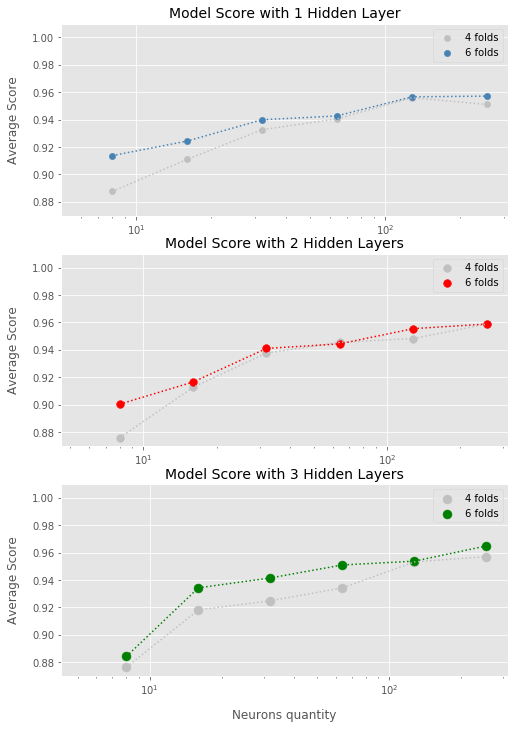

In [128]:
f, ax = plt.subplots(3,1,figsize=(8,12))

# 1 hidden layer - 4 folds
ax[0].plot(neurons_q, avg_scores_1hl_4f, c='silver', ls=':')
ax[0].scatter(neurons_q, avg_scores_1hl_4f, s=40, c='silver', label='4 folds')
# 1 hidden layer - 6 folds
ax[0].plot(neurons_q, avg_scores_1hl_6f, c='steelblue', ls=':')
ax[0].scatter(neurons_q, avg_scores_1hl_6f, s=40, c='steelblue', label='6 folds')

# 2 hidden layers - 4 folds
ax[1].plot(neurons_q, avg_scores_2hl_4f, c='silver', ls=':')
ax[1].scatter(neurons_q, avg_scores_2hl_4f, s=60, c='silver', label='4 folds')
# 2 hidden layers - 6 folds
ax[1].plot(neurons_q, avg_scores_2hl_6f, c='r', ls=':')
ax[1].scatter(neurons_q, avg_scores_2hl_6f, s=60, c='r', label='6 folds')

# 3 hidden layers - 4 folds
ax[2].plot(neurons_q, avg_scores_3hl_4f, c='silver', ls=':')
ax[2].scatter(neurons_q, avg_scores_3hl_4f, s=80, c='silver', label='4 folds')
# 3 hidden layers - 6 folds
ax[2].plot(neurons_q, avg_scores_3hl_6f, c='green', ls=':')
ax[2].scatter(neurons_q, avg_scores_3hl_6f, s=80, c='green', label='6 folds')

# Plot setup
ax[0].set_title('Model Score with 1 Hidden Layer', size=14)
ax[1].set_title('Model Score with 2 Hidden Layers', size=14)
ax[2].set_title('Model Score with 3 Hidden Layers', size=14)
ax[2].set_xlabel('Neurons quantity', labelpad=12)

for idx in range(3):
    ax[idx].set_ylabel('Average Score', labelpad=12)
    ax[idx].set_xscale('log')
    ax[idx].set_ylim(0.87, 1.01)
    ax[idx].legend()

plt.show()

The plot above confirms that the model performance is improved when using more folds. This is valid for the 3 test cases with different hidden layers quantity.

### Modifying the default learning rate
The learning rate is a parameter that may change the speed and final accuracy of the model. Lets try by increasing its default value. We will keep 6 folds.

#### 20 times higher learning rate

In [129]:
n_folds = 6

avg_scores_1hl_6f_20x = []
avg_scores_2hl_6f_20x = []
avg_scores_3hl_6f_20x = []

for n in neurons_q:
    scores_1hl = cross_validate(data, target, (n,), n_folds, learning_rate_init=0.02)
    scores_2hl = cross_validate(data, target, (n,n), n_folds, learning_rate_init=0.02)
    scores_3hl = cross_validate(data, target, (n,n,n), n_folds, learning_rate_init=0.02)

    avg_scores_1hl_6f_20x.append(np.mean(scores_1hl))
    avg_scores_2hl_6f_20x.append(np.mean(scores_2hl))
    avg_scores_3hl_6f_20x.append(np.mean(scores_3hl))

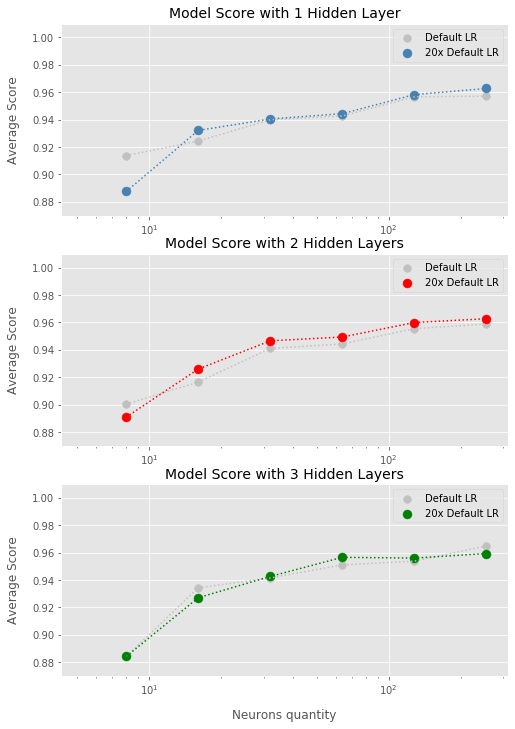

In [136]:
f, ax = plt.subplots(3,1,figsize=(8,12))
s1 = 'Default LR'
s2 = '20x Default LR'
# 1 hidden layer - default learning rate
ax[0].plot(neurons_q, avg_scores_1hl_6f, c='silver', ls=':')
ax[0].scatter(neurons_q, avg_scores_1hl_6f, s=60, c='silver', label=s1)
# 1 hidden layer - 20x default learning rate
ax[0].plot(neurons_q, avg_scores_1hl_6f_20x, c='steelblue', ls=':')
ax[0].scatter(neurons_q, avg_scores_1hl_6f_20x, s=80, c='steelblue', label=s2)

# 2 hidden layers - default learning rate
ax[1].plot(neurons_q, avg_scores_2hl_6f, c='silver', ls=':')
ax[1].scatter(neurons_q, avg_scores_2hl_6f, s=60, c='silver', label=s1)
# 2 hidden layers - 20x default learning rate
ax[1].plot(neurons_q, avg_scores_2hl_6f_20x, c='r', ls=':')
ax[1].scatter(neurons_q, avg_scores_2hl_6f_20x, s=80, c='r', label=s2)

# 3 hidden layers - default learning rate
ax[2].plot(neurons_q, avg_scores_3hl_6f, c='silver', ls=':')
ax[2].scatter(neurons_q, avg_scores_3hl_6f, s=60, c='silver', label=s1)
# 3 hidden layers - 20x default learning rate
ax[2].plot(neurons_q, avg_scores_3hl_6f_20x, c='green', ls=':')
ax[2].scatter(neurons_q, avg_scores_3hl_6f_20x, s=80, c='green', label=s2)

# Plot setup
ax[0].set_title('Model Score with 1 Hidden Layer', size=14)
ax[1].set_title('Model Score with 2 Hidden Layers', size=14)
ax[2].set_title('Model Score with 3 Hidden Layers', size=14)
ax[2].set_xlabel('Neurons quantity', labelpad=12)

for idx in range(3):
    ax[idx].set_ylabel('Average Score', labelpad=12)
    ax[idx].set_xscale('log')
    ax[idx].set_ylim(0.87, 1.01)
    ax[idx].legend()

plt.show()

#### 50 times higher learning rate

In [132]:
n_folds = 6

avg_scores_1hl_6f_50x = []
avg_scores_2hl_6f_50x = []
avg_scores_3hl_6f_50x = []

neurons_q = [8, 16, 32, 64, 128, 256]

for n in neurons_q:
    scores_1hl = cross_validate(data, target, (n,), n_folds, learning_rate_init=0.05)
    scores_2hl = cross_validate(data, target, (n,n), n_folds, learning_rate_init=0.05)
    scores_3hl = cross_validate(data, target, (n,n,n), n_folds, learning_rate_init=0.05)

    avg_scores_1hl_6f_50x.append(np.mean(scores_1hl))
    avg_scores_2hl_6f_50x.append(np.mean(scores_2hl))
    avg_scores_3hl_6f_50x.append(np.mean(scores_3hl))

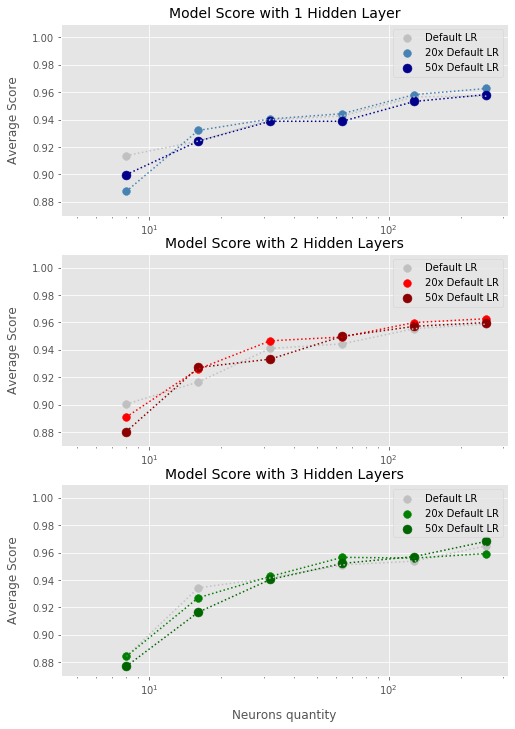

In [135]:
f, ax = plt.subplots(3,1,figsize=(8,12))
s1 = 'Default LR'
s2 = '20x Default LR'
s3 = '50x Default LR'
# 1 hidden layer - default learning rate
ax[0].plot(neurons_q, avg_scores_1hl_6f, c='silver', ls=':')
ax[0].scatter(neurons_q, avg_scores_1hl_6f, s=60, c='silver', label=s1)
# 1 hidden layer - 20x default learning rate
ax[0].plot(neurons_q, avg_scores_1hl_6f_20x, c='steelblue', ls=':')
ax[0].scatter(neurons_q, avg_scores_1hl_6f_20x, s=60, c='steelblue', label=s2)
# 1 hidden layer - 50x default learning rate
ax[0].plot(neurons_q, avg_scores_1hl_6f_50x, c='darkblue', ls=':')
ax[0].scatter(neurons_q, avg_scores_1hl_6f_50x, s=80, c='darkblue', label=s3)

# 2 hidden layers - default learning rate
ax[1].plot(neurons_q, avg_scores_2hl_6f, c='silver', ls=':')
ax[1].scatter(neurons_q, avg_scores_2hl_6f, s=60, c='silver', label=s1)
# 2 hidden layers - 20x default learning rate
ax[1].plot(neurons_q, avg_scores_2hl_6f_20x, c='r', ls=':')
ax[1].scatter(neurons_q, avg_scores_2hl_6f_20x, s=60, c='r', label=s2)
# 2 hidden layer - 50x default learning rate
ax[1].plot(neurons_q, avg_scores_2hl_6f_50x, c='darkred', ls=':')
ax[1].scatter(neurons_q, avg_scores_2hl_6f_50x, s=80, c='darkred', label=s3)

# 3 hidden layers - default learning rate
ax[2].plot(neurons_q, avg_scores_3hl_6f, c='silver', ls=':')
ax[2].scatter(neurons_q, avg_scores_3hl_6f, s=60, c='silver', label=s1)
# 3 hidden layers - 20x default learning rate
ax[2].plot(neurons_q, avg_scores_3hl_6f_20x, c='green', ls=':')
ax[2].scatter(neurons_q, avg_scores_3hl_6f_20x, s=60, c='green', label=s2)
# 3 hidden layer - 50x default learning rate
ax[2].plot(neurons_q, avg_scores_3hl_6f_50x, c='darkgreen', ls=':')
ax[2].scatter(neurons_q, avg_scores_3hl_6f_50x, s=80, c='darkgreen', label=s3)

# Plot setup
ax[0].set_title('Model Score with 1 Hidden Layer', size=14)
ax[1].set_title('Model Score with 2 Hidden Layers', size=14)
ax[2].set_title('Model Score with 3 Hidden Layers', size=14)
ax[2].set_xlabel('Neurons quantity', labelpad=12)

for idx in range(3):
    ax[idx].set_ylabel('Average Score', labelpad=12)
    ax[idx].set_xscale('log')
    ax[idx].set_ylim(0.87, 1.01)
    ax[idx].legend()

plt.show()

We observe in the above plot that there is no significant improvement when increasing the default learning rate. In some cases we obtain even worse results.

## Random Forest modeling
We will test MLP against a Random Forest algorithm to compare the performance.

In [140]:
# Redefine train(), using random forest
# We'll keep 'learning_rate_init' for compatibility purposes
def train(X, y, n=100, learning_rate_init=0.001):
    """
    Train a Random model and return the trained model
    """
    rf = RandomForestRegressor(n_estimators=n, random_state=0)
    rf.fit(X, y)

    return rf

In [142]:
# test with different neurons quantity in two hidden layer
avg_scores_rf = []
# Estimators quantity:
# 10 different test cases from 10^1=10 up to 10^2.5 = 316.
#trees_q = np.logspace(1, 2.5, 10, dtype=int)
trees_q = neurons_q

for n in trees_q:
    scores = cross_validate(data, target, n, n_folds=6)
    avg_scores_rf.append(np.mean(scores))

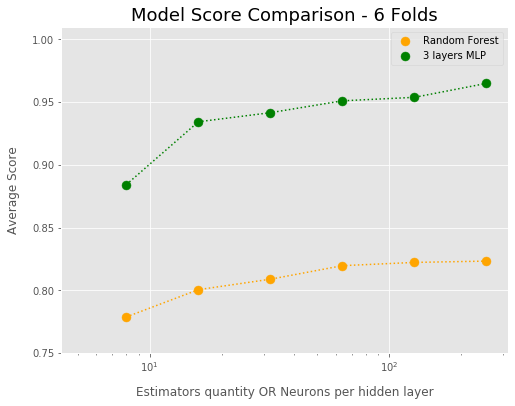

In [143]:
f, ax = plt.subplots(figsize=(8,6))

# Random forest
ax.plot(trees_q, avg_scores_rf, c='orange', ls=':')
ax.scatter(trees_q, avg_scores_rf, s=80, c='orange', label='Random Forest')

# MLP with 3 hidden layers
ax.plot(neurons_q, avg_scores_3hl_6f, c='g', ls=':')
ax.scatter(neurons_q, avg_scores_3hl_6f, s=80, c='g', label='3 layers MLP')

# Plot setup
ax.set_title('Model Score Comparison - 6 Folds', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Estimators quantity OR Neurons per hidden layer', labelpad=12)
ax.set_xscale('log')
ax.set_ylim(0.75, 1.01)
ax.legend()
plt.show()

The above plot shows that Random Forest is not useful in this kind of project compared to the MLP performance.

## Visualization of MLP weights 
Sometimes looking at the learned coefficients of a neural network can provide insight into the learning behavior. For example if weights look unstructured, maybe some were not used at all, or if very large coefficients exist, maybe regularization was too low or the learning rate too high.

In [144]:
def cross_validate_and_visualize(features, labels, n, n_folds=4):
    """
    Validation based on train/test split using K-Folding
    An optional visualization is added with parameter 'show_visualization'
    """
    accuracies = []
    
    kf = KFold(n_splits = n_folds, random_state=0)
    
    fold_counter = 1
    for train_idx, test_idx in kf.split(features):
        print('Fold number {}'.format(fold_counter))
        print(40*'-')
        # 'X' as features and 'y' as labels
        X = features.loc[train_idx]
        y = labels.loc[train_idx]
        X_test = features.loc[test_idx]
        y_test = labels.loc[test_idx]

        # Model training and testing
        model = MLPClassifier(hidden_layer_sizes=n, max_iter=1000,
                              learning_rate_init=.005)
        model.fit(X, y)
        model_score = test(model, X_test, y_test)
        accuracies.append(model_score)
        
        print("Training set score: %f" % model.score(X, y))
        print("Test set score: %f" % model.score(X_test, y_test))
        
        fold_counter += 1
        
        # Visualization of MLP weights
        fig, ax = plt.subplots(8, 8,figsize=(6,6))
        # use global min / max to ensure all weights are shown on the same scale
        vmin, vmax = model.coefs_[2].min(), model.coefs_[2].max()
        # Showing only the last hidden layer
        for coef, ax in zip(model.coefs_[2].T, ax.ravel()):
            ax.matshow(coef.reshape(8, 8), cmap=plt.cm.gray, vmin=.5 * vmin,
                       vmax=.5 * vmax)
            ax.set_xticks(())
            ax.set_yticks(())
        plt.show()
        
    return accuracies

Fold number 1
----------------------------------------
Training set score: 1.000000
Test set score: 0.926667


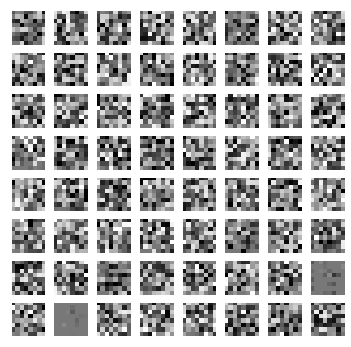

Fold number 2
----------------------------------------
Training set score: 1.000000
Test set score: 0.939866


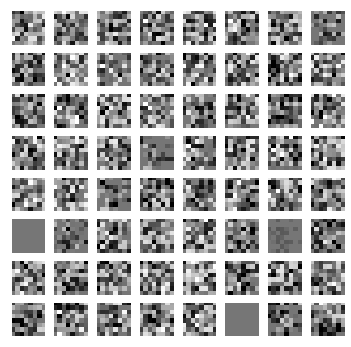

Fold number 3
----------------------------------------
Training set score: 1.000000
Test set score: 0.953229


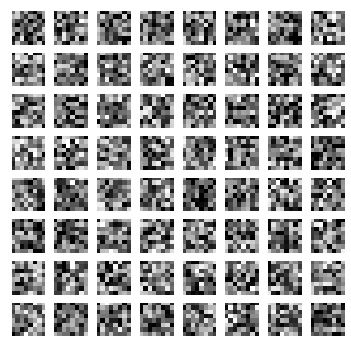

Fold number 4
----------------------------------------
Training set score: 1.000000
Test set score: 0.913140


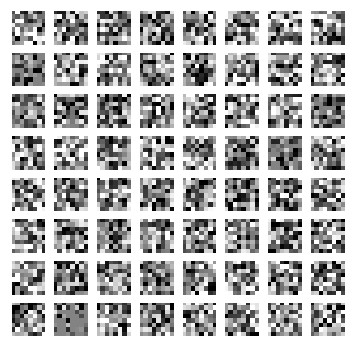

In [66]:
score = cross_validate_and_visualize(data, target, (64,64,64))

## Summary
For this kind of project, a **K-Nearest Neighbor** (KNN) performed reasonably. However, there are a few downsides to using k-nearest neighbors:

- High memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- No model representation to debug and explore
  
We test also **MLP Classifier** models, which is a feedforward neural network with hidden layers of neurons. They perform better when we increase the numbers of neurons. If we increase also the number of hidden layers, we will reach a higher performance as well.

When comparing MLP models using 1, 2 and 3 layers, we observed:
- Maximum performance, slightly above 96%. Reached in this particular case when using 2 hidden layers and 256 neurons per layer.
- There is no linearity between model performance and layer quantity but there is a tendency to have better performance when incrementing the hidden layers and / or neurons per layer.
- With more than 64 neurons per layer, there is not much improvement in performance for this particular case.

Regarding the **train** and **test** sets, we started with a 4 folds method and then increased to 6 folds. The later showed that the performance of the model improved even more.

Then we modified the default learning rate parameter for the MLP model. The first test uses a 20 times higher value while the second 50 times. The test show that there is no significant improvement for this particular case and we may obtain even worst results. The convergence time, however, should be decreased. This is out of scope for this project.

The next step is regarding a random forest comparison. We compared the performance of a random forest algorithm with an MLP. MLP performs much better for this application, since a random forest showed a performance lower than 82%, although is much faster.

A final section in this project is to visualize the MLP weights. The advantage of the MLP architecture is that we have access to what is going on inside the model (in some level). This brings the possibility to show the weights as images. We think that the results shown in the test could be improved but it is out of scope for now.